# Unsupervised ML for Feature Engineering 

Let me start this notebook with a quote from well-known CS researcher and Data Scientist Pedro Domingos' famous paper [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf).

> “At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used. If you have many independent features that each correlate well with the class, learning is easy. On the other hand, if the class is a very complex function of the features, you may not be able to learn it. Often, the raw data is not in a form that is amenable to learning, but you can construct features from it that are. This is typically where most of the effort in a machine learning project goes.” 

Here, I'll focus on a limited part - feature selection, derived from feature engineering - of this quote. And my vehicle to engineer featuires into a new feature representation will be some forms of *dimensionality reduction*.  

## Differential Feature Importance: Demo

Demo below is to show that (i) not all features are important, and that (ii) the unimportant ones can be identified easily in many cases. 

See below an example with the by-now-familiar MNIST dataset of handwritten digits, each of image size 28x28 pixels.

The digit occupies the central area of each image and clearly the outer all-white margins are easily identifiable as unimportant.

Unimp and hence discardable, perhaps? Behold.


In [1]:
# setup chunk
import numpy as np
import pandas as pd
import time

from sklearn.ensemble import RandomForestClassifier

# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Loading the MNIST data for the Demo

In [2]:
# DC for (again) MNIST
t1 = time.time()
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
    
t2 = time.time()
print(round(t2-t1, 2), " secs")  # 38 secs
print("\n")

# explore data size etc again
print(mnist["data"].shape)

40.67  secs


(70000, 784)


Again, there are 28x28=784 pixels == features in MNIST digits dataset.

I'll next use the Random Forest classifier to classify the images into digits (we've seen that already) but in the process examine feature importance.

### Running RF classifier on MNIST

Idea is to see how many features turn out to be uninformative and hence irrelevant to the classification job.

Behold.

In [3]:
## run RF on MNIST on those 784 features
from sklearn.ensemble import RandomForestClassifier

t1 = time.time()
# instantiate and fit the RF classifier
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

t2 = time.time()
print(round(t2-t1, 2))  # 6.2 secs

# examine feature importance vector output
feat_impce_vector = rnd_clf.feature_importances_  # numpy 1-D array
feat_impce_vector[:10]  # View a few entries
np.sort(feat_impce_vector)[::-1][:15]  # sort descending and view 

6.34


array([0.01242113, 0.01228553, 0.01058784, 0.0104413 , 0.01039486,
       0.01028501, 0.01020469, 0.00911813, 0.00880466, 0.00872869,
       0.00865308, 0.00864893, 0.00852753, 0.00834558, 0.00826838])

### Plot and see feature (pixel) importance

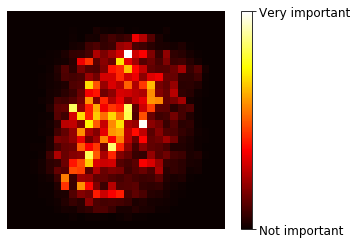

In [6]:
# import modules for plotting pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# define plot func first
def plot_digit(data):  
    image = data.reshape(28, 28)  # reorder pixels back into a 28x28 img
    plt.imshow(image, 
               cmap = mpl.cm.hot, # use color palettes & interpolate for gaps
               interpolation="nearest")
    plt.axis("off")

# now invoke plotting func on rnd_clf.feature_importances_
plot_digit(feat_impce_vector)
cbar = plt.colorbar(ticks=[feat_impce_vector.min(), feat_impce_vector.max()]) # build colorbar
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()        

Few things that jump out from the above figure.

- One, the darkest (most unimportant) features (i.e. pixels) are all at the outer margins. Eminently discardable without losing info.<p>

- Two, the central portion is a multicolored mess partly because different digits trace different shapes there. <p> 

- Three, whether light or dark, two neighbouring pixels tend to be correlated more often than not, and if we merge them into a single pixel, we shouldn't lose too much info. <p>

- Four, merging pixels is == reducing number of features == reducing dimensionality in a way. <p>

Back to the slides briefly before we head to our next topic - **Manifold learning** via its canonical example, the swiss roll.
    
## The Swiss Roll dataset

Projection isn't always the best option for dimensionality reduction. 

In many cases, the subspace may twist and turn in a higher dimensional space causing projection problems.

How better to see this than to actually *see* it? Hence, we head to the canonical **swiss roll** example. 

The Swiss Roll dataset is a 2-D plane twisting and turning in 3-D space in a way that disallows easy projection based classification boundaries.

Code below helps generate the swiss roll and its various classes in Py's matplotlib. 

Behold.

X size is:  (1000, 3) class labels size:  (1000,)


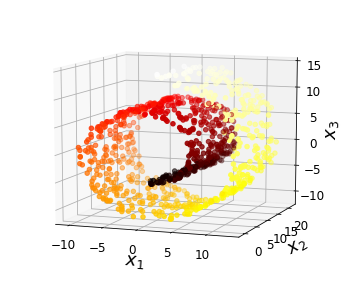

In [7]:
# plot swiss roll
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
print("X size is: ", X.shape, "class labels size: ", t.shape)  # size of the X and target classes arrays

# plot stuff
axes = [-11.5, 14, -2, 23, -12, 15]
fig = plt.figure(figsize=(6, 5))

# instantiate the 3-d plot as 'ax'
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)  # heatmap color palette set

ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)

ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

See? The color-coding of classes suggests that if only we could **unroll** the rolled-up and twisted 2-D plane, we could easily get classification boundaries.

The 2-D plane is IOW a 2-D *manifold* folded up in 3-D space. In the fig below, left side plot is the 2-D unrolled manifold. 

Projection won't help in unrolling a manifold. We can try however and the resulting *squished* manifold is what we see on the right subplot.

Behold.

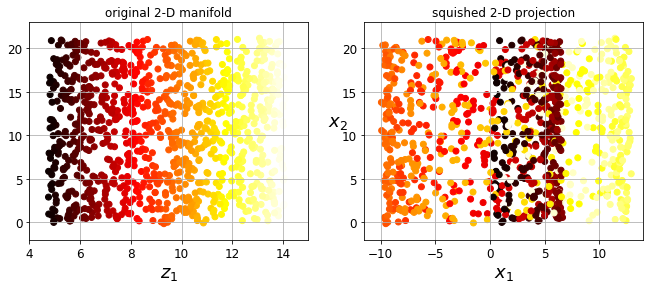

In [8]:
# plot 2 subplots side by side
plt.figure(figsize=(11, 4))

# original manifold unrolled
plt.subplot(121)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.title("original 2-D manifold")
plt.grid(True)

# squished swiss roll in a 2-D projection
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.title("squished 2-D projection")
plt.grid(True)

plt.show()

The *manifold hypothesis* states that most real-world high-dimensional datasets lie close to a much lower dimensional manifold.

Empirical observations give good support to the manifold assumption. E.g., think about cross-image similarities in MNIST handwritten digits data - connected lines, white margins, centering etc.

Alternately, if you were to randomly generate pixels on a 28x28 space, what fraction would look anything like a digit? 

If that fraction is ridiculously tiny, then the manifold assumption likely applies.

Next we head to the most common of the Projection techniques and get an intuition for what it does.

## Projection Techniques: PCA

PCA is by far the most popular dimensionality reduction algo. Lik all projection techniqes, it identifies a (hyper)plane closest to the data and projects data onto it.

PCA identifies that axis among countless possible ones that *maximizes data variance* and makes it the first PC. 

Then it searches among the countless possible orthogonal  axes for the one that maximizes the next highest variance and so on and so forth.

For a gentle intro, head down to the slides first pls.

### Implementing PCA on MNIST


In [9]:
from sklearn.model_selection import train_test_split
# train-test-split MNIST into 60k:10k
train_x, test_x, train_y, test_y = train_test_split(
    mnist.data, mnist.target, test_size=1/7.0, random_state=0)

print(train_x.shape)
print("\n")
print(test_x.shape)

(60000, 784)


(10000, 784)


### Standardize Data's scale

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales.

Standardization of a dataset is a common requirement in many ML estimators: they might behave badly if the individual feature scales vary wildly. 

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # instantiate scaler

# Fit on training set only.
scaler.fit(train_x)

# Apply transform to both the training set and the test set.
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

Aim below is to demo how feature engg such as dimensionality reduction can sometimes greatly speed-up ML techniques.

## Getting re-engineered features from PCA

Below, I demo how well ML *learns* patterns in data enough to ID digits accurately, using Logistic classification as an example ML estimator.

Behold.

In [17]:
# import and instantiate model
from sklearn.decomposition import PCA
pca = PCA(.95)  # find min #compts that capture 95% of variance
t1 = time.time()
pca.fit(train_x)
print("PCA fitting on MNIST took: ", round(time.time()-t1, 2), " secs.")  # 8.6 secs
print("\n")
print("Min #compts required is: ", pca.n_components_)  # how many compts meet above criterion? # 327

# Apply the mapping (transform) to both the training set and the test set.
train_x = pca.transform(train_x)
test_x = pca.transform(test_x)

from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')  # instantiate model

PCA fitting on MNIST took:  2.19  secs.


Min #compts required is:  189


LogReg model below learns the relationship between x (digits) and y (labels).

Follows usual path of instantiation, fit, transform and predict.

In [18]:
t1 = time.time()
logisticRegr.fit(train_x, train_y)  # fit model on training sample
print("LogReg fitting on MNIST took: ", round(time.time()-t1, 2), " secs.")  # 10 secs

LogReg fitting on MNIST took:  8.74  secs.


C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Not bad, eh? <11 secs to train a model to learn about the relations between 337 features and 1 outcome for each opf 60k samples.

Next we use the trained model to predict the labels of new data (new images). 

In [19]:
# Predict for Multiple Observations (images) at Once
pred_vals = logisticRegr.predict(test_x[0:1000]).tolist()

out_df = pd.DataFrame({'Actual_vals': test_y[0:1000], 'Pred_vals':pred_vals})
out_df.head(20)

print("predicted values are: ", pred_vals[0:10])
print("\n")
print("actual values are: ", test_y[0:10])

predicted values are:  [0, 4, 1, 2, 4, 7, 7, 1, 1, 7]


actual values are:  [0 4 1 2 7 9 7 1 1 7]


## Measuring Model Performance

Accuracy is basically the fraction of correct predictions, computed as  correct predictions / total number of data points.

This is our mot basic metric of how the model performs on new data (test set). The .score() func computes this for us. 

In [20]:
score = logisticRegr.score(test_x, test_y)
print("accuracy is: ", score)

accuracy is:  0.9191


How far can we go? Suppose I use only a tenth, say 32, of the 327 components? By how much will my performance change? 

Only one way to find out that I can see...

P.S. Below, I encode all the steps we did above into a custom function that'll be easy to invoke whenever needed. 

Behold.

In [21]:
# define custom func to run all steps above
def pca_feature_engg(n_compts, X, y):
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=1/7.0, random_state=0)
    scaler = StandardScaler()  # instantiate scaler

    scaler.fit(train_x) # Fit on training set only.

    # Apply transform to both the training set and the test set.
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
    pca = PCA(n_components = n_compts)
    pca.fit(train_x)
    
    # Apply the mapping (transform) to both the training set and the test set.
    train_x = pca.transform(train_x)
    test_x = pca.transform(test_x)
    print("PCA transfmns done and dataShape now is: ", train_x.shape) # to track progress
    
    varExpl_list = pca.explained_variance_ratio_.cumsum().tolist()
    a0 = len(varExpl_list) - 1
    tot_varExpl = round(varExpl_list[a0], 3)
    
    logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=500)  # instantiate model
    logisticRegr.fit(train_x, train_y)  # fit model on training sample
    print("classifier fitting done")
    
    # print accuracy
    score = logisticRegr.score(test_x, test_y)
    print("accuracy is: ", score)
    print("=================\n")
    return(score, tot_varExpl)

# time and apply func above to 30 compts   
X, y = mnist["data"], mnist["target"]

t1 = time.time()
score_30, varExpl1 = pca_feature_engg(30, X, y)
t2 = time.time()    

print("Accuracy with ncompts=30: ", score_30)
print("Tot Variance Explained with ncompts=30: ", varExpl1)
print("Time taken was: ", round(t2-t1, 2))

PCA transfmns done and dataShape now is:  (60000, 30)
classifier fitting done
accuracy is:  0.8872

Accuracy with ncompts=30:  0.8872
Tot Variance Explained with ncompts=30:  0.454
Time taken was:  23.03


Hmmm. Accuracy fell of sorts to 88.7%. How much farther can we go? Whynot try n_compts = 10 or 50 or 100?

Again, another programming practice - looping in the custom func to test other values of interest.

Watch.

In [22]:
# define list of n_compts values to test for
nCompts_list = [1, 5, 10, 25, 50, 75, 100, 150, 200, 300, 500]
print(nCompts_list)
print("\n")
accu_score = []  # define empty list to capture scores
tot_varExpl = []  # define empty list to capture scores

# looping in above list. Also time the op
t1 = time.time()

for i in nCompts_list:    
    print("proc run for n_compts = ", i)
    score1, varExpl1 = pca_feature_engg(i, X, y)
    accu_score.append(score1)
    tot_varExpl.append(varExpl1)    
    
t2 = time.time()
print("Time taken was: ", round(t2-t1, 2))
print("\n")

# print results
out_df = pd.DataFrame({'PCA_compts': nCompts_list, 
                       'Tot_var_expl':tot_varExpl, 
                       'accuracy':accu_score})
    
out_df    # view results wala dataframe

[1, 5, 10, 25, 50, 75, 100, 150, 200, 300, 500]


proc run for n_compts =  1
PCA transfmns done and dataShape now is:  (60000, 1)
classifier fitting done
accuracy is:  0.3043

proc run for n_compts =  5
PCA transfmns done and dataShape now is:  (60000, 5)
classifier fitting done
accuracy is:  0.6757

proc run for n_compts =  10
PCA transfmns done and dataShape now is:  (60000, 10)
classifier fitting done
accuracy is:  0.7983

proc run for n_compts =  25
PCA transfmns done and dataShape now is:  (60000, 25)
classifier fitting done
accuracy is:  0.8765

proc run for n_compts =  50
PCA transfmns done and dataShape now is:  (60000, 50)
classifier fitting done
accuracy is:  0.9032

proc run for n_compts =  75
PCA transfmns done and dataShape now is:  (60000, 75)


C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


classifier fitting done
accuracy is:  0.9108

proc run for n_compts =  100
PCA transfmns done and dataShape now is:  (60000, 100)


C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


classifier fitting done
accuracy is:  0.914

proc run for n_compts =  150
PCA transfmns done and dataShape now is:  (60000, 150)


C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


classifier fitting done
accuracy is:  0.9197

proc run for n_compts =  200
PCA transfmns done and dataShape now is:  (60000, 200)


C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


classifier fitting done
accuracy is:  0.9202

proc run for n_compts =  300
PCA transfmns done and dataShape now is:  (60000, 300)


C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


classifier fitting done
accuracy is:  0.9196

proc run for n_compts =  500
PCA transfmns done and dataShape now is:  (60000, 500)
classifier fitting done
accuracy is:  0.9174

Time taken was:  615.66




C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,PCA_compts,Tot_var_expl,accuracy
0,1,0.057,0.3043
1,5,0.190,0.6757
2,10,0.278,0.7983
3,25,0.421,0.8765
4,50,0.555,0.9032
5,75,0.642,0.9108
6,100,0.709,0.9140
7,150,0.804,0.9197
8,200,0.869,0.9202
9,300,0.939,0.9196


Running above in class is optional as you can see it will take a full few minutes of class time. 

Options exist to drastically reduce time taken such parallel-processing via multiple instances or multiple cores in a machine etc. But that story is for some other time.

OK, now back to the outputted dataframe. What jumps out at you from there? Some notes that I made:

1. As n_compts increases, so does accuracy for the most part. Unsurprising as ever more info from the original data are retained with rise in n_compts.

2. However, the **rate of increase** of accuracy with n_compts is  NOT uniform. The first few components show the sharpest increases (i.e., steepest learning curves). *Why?*

In fact, below let me plot the rate of change so that we can *see* just how steep things get.

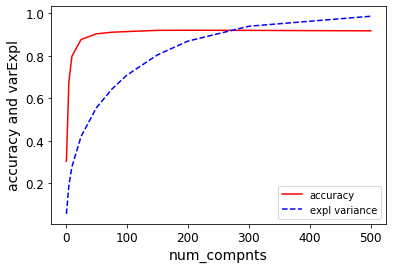

In [23]:
# plot change in accuracy against n_compts
plt.plot(out_df['PCA_compts'], out_df['accuracy'], 'r-', label="accuracy")  # plot accuracy in red
plt.plot(out_df['PCA_compts'], out_df['Tot_var_expl'], 'b--', label="expl variance")  # plot varianced_Explained in blue
plt.xlabel('num_compnts')
plt.ylabel('accuracy and varExpl')
plt.legend()
plt.show()

3. Because PCA creates PCs explicitly to maximize variance explained, the first PC will have maximum variance explained, the next one will have second highest variance explained and so on. Scan the middle column in out_df to  see this in action.

4. Note what PCA did - it transformed (rather, *engineered*) the original 784 features into a smaller, denser, more condensed and coherent set of new features (represented by PCs) that could be utilized by the classifier.

P.S. We could have used Regularized regressions too with LogReg but that would only give us feature selection, not re-enginnered set of new dense features.

5. Could it be that for MINST data (or for image data in general?) PCA based feature engineering requires only a handful of PCs? We'll see later in the faces dataset.

6. PCA is just one of many (unsupervised) methods available in a data scientist's feature engg toolkit. We'll see a few more in a later lecture on unsupervised learning.

7. LogReg was just one classifier that we used. Others could have been tried as well such as the SGD classifier. In fact the func we defined could be made more general and a classifier argument could be added as input to the function!

8. Learning about programming flow via custom functions and basic (for-) looping we saw today. 

Chalo, back to slides briefly for an intro to manifolds, coming up next.

## Manifold learning with t-SNE

Recall the child-apple example used to illustrate the importance of and difficulty in understanding the *representation* of data best suited for a model to learn.

Manifold learning enables new representations of data with more complex mappings than are allowed for in projection techniques. 

Let's next study one of the most useful ones - t-SNE. Most manifold learning has to do with vsualization and so rarely do we need more than 3-Ds in the output.

Idea behind t-SNE is to find a 2-D data representation that best preserves inter-point distances. 

Behold.


In [24]:
# setup chunk
from sklearn.datasets import load_digits

# explore data
digits = load_digits()
print(digits.DESCR)  # dataset overview

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

The DESCR section shows clearly that this is related to MNIST, is speficially a benchmark for learner algos in OCR training and has a small size (8x8 pixels = 64 attributes).

Small size == low resolution etc. Can plot and see just how low.

### Explore digits dataset

Below, some basic data dimensionality and plot exploration etc.

X data size:  (1797, 64)
target size:  (1797,)
target names:  [0 1 2 3 4 5 6 7 8 9]



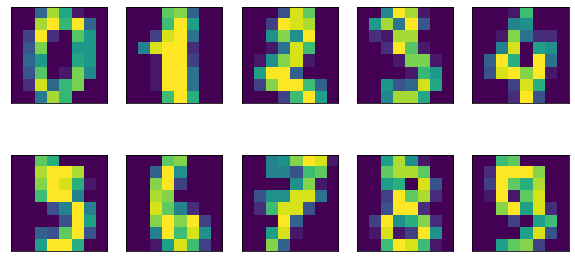

In [25]:
print("X data size: ", digits.data.shape)
print("target size: ", digits.target.shape)
print("target names: ", digits.target_names)
print("=======\n")

# view a few
fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':(), 'yticks': ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

Below I propose to buld a projection based technqiue (PCA) to 2-D visualize class separation. 

Then we will rpeeat the same with t-SNE. 

### PCA performance baseline

Behold.

Text(0, 0.5, 'Second principal component')

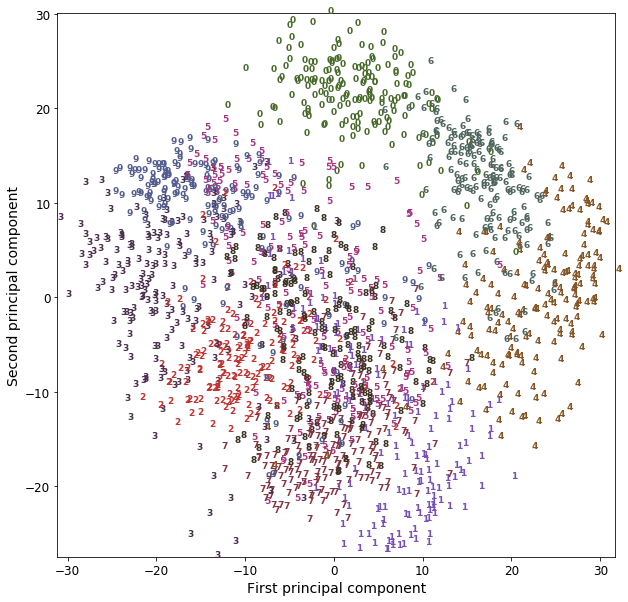

In [26]:
# build a PCA model
pca = PCA(n_components=2)
pca.fit(digits.data)

# transform the digits data onto the first two principal components
digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

plt.figure(figsize=(10, 10))
plt.xlim(digits_pca[:, 0].min(), digits_pca[:, 0].max())
plt.ylim(digits_pca[:, 1].min(), digits_pca[:, 1].max())

for i in range(len(digits.data)):

    # actually plot the digits as text instead of using scatter
    plt.text(digits_pca[i, 0], digits_pca[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("First principal component")
plt.ylabel("Second principal component")

Notes from the 2-D visualization above. <p>

- The digits zero, six and four are relatively well-separated in 2-D PCA. <p>

- Most of the other digits overlap significantly.

## Doing the same on t-SNE

time taken:  -123.79  secs


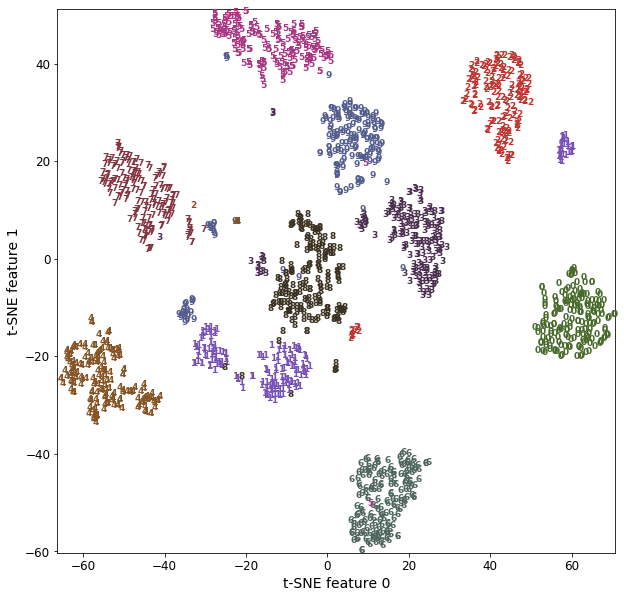

In [27]:
# import and instantiate
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)

# use fit_transform instead of fit, as TSNE has no transform method
t1 = time.time()
digits_tsne = tsne.fit_transform(digits.data)

# plot 2-D from t-SNE
plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)

for i in range(len(digits.data)):

    # actually plot the digits as text instead of using scatter
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(digits.target[i]),
             color = colors[digits.target[i]],
             fontdict={'weight': 'bold', 'size': 9})

plt.xlabel("t-SNE feature 0")
plt.ylabel("t-SNE feature 1")

t1 = time.time()
print("time taken: ", round(t2-t1,2), " secs")

Quite remarkable, eh?

- *All* the classes are clearly separated! ('cept the ones and nines a tad).<p>

- Keep in mind that the method had no knowledge of class labels! (Unsupervised, duh).<p>

- Yet it finds a 2-D representation of the data based solely on inter-point distances in the original space.<p>
    
t-SNE is typically used for visualization. Other manifold learning techniques exist but will stop here for now. Back to the slides.
    
Voleti